In [1]:
import math
from collections import namedtuple
import plotly.graph_objects as go
import plotly.express as px
import numpy as np
from copy import deepcopy
from tqdm import tqdm
from tqdm.notebook import tqdm
import random

import numba as nb
# from numba import jit, vectorize, float64

In [2]:
## fl_25_2 3269821.320531
## fl_50_6 3758677.362987, 3732793.4337715516
## fl_100_7 1965.554497
## fl_100_1 24099243.003001
## fl_200_7 4835097.464818
## fl_500_7 28472847.747679
## fl_1000_2 9220498.730082
## fl_2000_2 7770216.354847

In [194]:
filename = 'fl_500_7'

with open(f"./data/{filename}", "r") as input_data_file:
    input_data = input_data_file.read()
    
lines = input_data.split('\n')

parts = lines[0].split()
facility_count = int(parts[0])
customer_count = int(parts[1])

facilities = []
for i in range(1, facility_count+1):
    parts = lines[i].split()
    facilities.append([i-1, float(parts[0]), int(parts[1]), float(parts[2]), float(parts[3])])

customers = []
for i in range(facility_count+1, facility_count+1+customer_count):
    parts = lines[i].split()
    customers.append([i-1-facility_count, int(parts[0]), float(parts[1]), float(parts[2])])


facilities = np.array(facilities)
customers = np.array(customers)

In [195]:
facility_count, customer_count

(500, 3000)

In [196]:
@nb.jit(nopython=True)
def length_distance(single_point, all_points):
    return np.sqrt((all_points[:, 0]-single_point[0])**2 + (all_points[:, 1]-single_point[1])**2)



def reassignment_cost(scrutiny_locations, total_cost, facilities, customers):
    optimal_cost = total_cost
    optimal_mapping = deepcopy(CUSTOMER_MAPPING)
    optimal_facility_in_use = deepcopy(FACILITY_IN_USE)
    optimal_facility_capacity = deepcopy(FACILITY_REMAINING_CAPACITY)

    for fc_idx in scrutiny_locations:
        new_cost = total_cost
        altering_facility_in_use = deepcopy(FACILITY_IN_USE)
        altering_customer_mapping = deepcopy(CUSTOMER_MAPPING)
        altering_facility_capacity = deepcopy(FACILITY_REMAINING_CAPACITY)
        
        altering_facility_in_use[fc_idx] = 0
        active_locations = np.where(altering_facility_in_use == 1)[0]
        abandoned_customers = np.where(altering_customer_mapping == fc_idx)[0]
        
        # Unassign. Remove cost because closing the facility
        new_cost -= facilities[fc_idx][1]

        for cx_idx in abandoned_customers:
            altering_customer_mapping[cx_idx] = -1

        
        for cx_idx in abandoned_customers:

            customer_demand = customers[cx_idx][1]            
            facility_options = np.argsort(CUSTOMER_MATRIX[cx_idx])
            
            for fco in facility_options:

                if fco == fc_idx or fco not in active_locations:
                    continue

                facility_capacity = altering_facility_capacity[fco]
                
                if facility_capacity-customer_demand >= 0:
                    ## remove old cost
                    new_cost -= CUSTOMER_MATRIX[cx_idx][fc_idx]
                    altering_facility_capacity[fc_idx] += customer_demand

                    ## add new cost
                    new_cost += CUSTOMER_MATRIX[cx_idx][fco]
                    altering_facility_capacity[fco] -= customer_demand
                    altering_customer_mapping[cx_idx] = fco
                    break

        if new_cost < optimal_cost and -1 not in altering_customer_mapping:
            optimal_cost = new_cost
            optimal_mapping = deepcopy(altering_customer_mapping)
            optimal_facility_in_use = deepcopy(altering_facility_in_use)
            optimal_facility_capacity = deepcopy(altering_facility_capacity)

    return optimal_cost, optimal_mapping, optimal_facility_in_use, optimal_facility_capacity





def reroute_cx(cx, total_cost, facilities, customers):
    
    optimal_cost = total_cost
    optimal_mapping = deepcopy(CUSTOMER_MAPPING)
    optimal_facility_in_use = deepcopy(FACILITY_IN_USE)
    optimal_facility_capacity = deepcopy(FACILITY_REMAINING_CAPACITY)
    
    new_cost = total_cost
    altering_facility_in_use = deepcopy(FACILITY_IN_USE)
    altering_customer_mapping = deepcopy(CUSTOMER_MAPPING)
    altering_facility_capacity = deepcopy(FACILITY_REMAINING_CAPACITY)
    
    current_facility = altering_customer_mapping[cx]
    for ideal_facility in np.argsort(CUSTOMER_MATRIX[cx]):
        if ideal_facility == current_facility or not altering_facility_in_use[ideal_facility]:
            continue
        break

    # ideal_facility = np.argsort(CUSTOMER_MATRIX[cx])[0]

    # if current_facility == ideal_facility:
    #     return optimal_cost, optimal_mapping, optimal_facility_in_use, optimal_facility_capacity 
    

    ##Swap the customer to ideal facility
    
    #give back the capacity to current facility
    altering_facility_capacity[current_facility] += customers[cx][1]
    new_cost -= CUSTOMER_MATRIX[cx][current_facility]
    
    #assign new facility
    altering_customer_mapping[cx] = ideal_facility
    
    #take capacity from ideal facility
    altering_facility_capacity[ideal_facility] -= customers[cx][1]
    new_cost += CUSTOMER_MATRIX[cx][ideal_facility]

    
    if new_cost < optimal_cost and np.where(altering_facility_capacity<0)[0].size == 0:
        optimal_cost = new_cost
        optimal_mapping = deepcopy(altering_customer_mapping)
        optimal_facility_capacity = deepcopy(altering_facility_capacity)
        return optimal_cost, optimal_mapping, optimal_facility_in_use, optimal_facility_capacity

    
    counter = 100
    visited = [cx]
    create_violation = True
    
    while (np.where(altering_facility_capacity<0)[0].size > 0 and counter > 0) or create_violation:

        create_violation = False
        
        best_change = float('inf')
        best_swap_facility = None
        best_swap_customer = None

        if np.where(altering_facility_capacity<0)[0].size > 0:
            ideal_facility = np.where(altering_facility_capacity<0)[0][0]
        
        serving_customers = np.where(altering_customer_mapping == ideal_facility)[0]
    
        for check_cx in serving_customers:
            for check_fac in np.argsort(FACILITY_MATRIX[ideal_facility]): ## Filter only active ones
                
                if check_fac == ideal_facility or not altering_facility_in_use[check_fac] or check_cx in visited:
                    continue
        
                delta_change = CUSTOMER_MATRIX[check_cx][check_fac]-CUSTOMER_MATRIX[check_cx][ideal_facility]
                added_cost_ideal_facility = altering_facility_capacity[ideal_facility]+customers[check_cx][1]
                remove_cost_current_facility = altering_facility_capacity[check_fac]-customers[check_cx][1]
        
                if delta_change < best_change and added_cost_ideal_facility>0 and remove_cost_current_facility>0:
                    best_change = delta_change
                    best_swap_customer = check_cx
                    best_swap_facility = check_fac

        if not best_swap_customer:
            break
            
        # take capacity from facility to swap
        altering_facility_capacity[best_swap_facility] -= customers[best_swap_customer][1]
        new_cost += CUSTOMER_MATRIX[best_swap_customer][best_swap_facility]
        
        #assign new facility
        altering_customer_mapping[best_swap_customer] = best_swap_facility
        
        #give back the capacity to ideal facility
        altering_facility_capacity[ideal_facility] += customers[best_swap_customer][1]
        new_cost -= CUSTOMER_MATRIX[best_swap_customer][ideal_facility]

        counter -= 1
        visited.append(best_swap_customer)
        
    
    if new_cost < optimal_cost and np.where(altering_facility_capacity<0)[0].size == 0:
        optimal_cost = new_cost
        optimal_mapping = deepcopy(altering_customer_mapping)
        optimal_facility_capacity = deepcopy(altering_facility_capacity)
        return optimal_cost, optimal_mapping, optimal_facility_in_use, optimal_facility_capacity
    else:
        return optimal_cost, optimal_mapping, optimal_facility_in_use, optimal_facility_capacity

In [197]:
FACILITY_MATRIX = np.zeros((facility_count, facility_count))

for facility in tqdm(facilities):
    idx = int(facility[0])
    FACILITY_MATRIX[idx] = length_distance(facility[3:], facilities[:, 3:])


CUSTOMER_MATRIX = np.zeros((customer_count, facility_count))

for customer in tqdm(customers):
    idx = int(customer[0])
    CUSTOMER_MATRIX[idx] = length_distance(customer[2:], facilities[:,3:])




  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

In [198]:
total_cost = 0

FACILITY_IN_USE = np.zeros(facility_count, dtype=int)
FACILITY_REMAINING_CAPACITY = facilities[:, 2].copy()

CUSTOMER_MAPPING = np.zeros(customer_count, dtype=int)


for cx_idx in range(customer_count):

    facility_options = np.argsort(CUSTOMER_MATRIX[cx_idx])
    
    for fc_idx in facility_options:
    
        facility_capacity = FACILITY_REMAINING_CAPACITY[fc_idx]
        customer_demand = customers[cx_idx][1]
        
        if facility_capacity-customer_demand >= 0:
        
            if not FACILITY_IN_USE[fc_idx]:
                FACILITY_IN_USE[fc_idx] = 1
                total_cost += facilities[fc_idx][1]
        
            total_cost += CUSTOMER_MATRIX[cx_idx][fc_idx]
            FACILITY_REMAINING_CAPACITY[fc_idx] -= customer_demand
        
            CUSTOMER_MAPPING[cx_idx] = fc_idx
    
            break
            
total_cost

38585497.36033943

In [199]:
temp_size = float('inf')

_, element_counts = np.unique(CUSTOMER_MAPPING, return_counts=True)
unique_facilities = np.unique(element_counts)

total_cost

38585497.36033943

In [200]:
## Close a facility and allocate the customer to different cost if the new cost is lower than previous cost.
## Only move the customer to facility that has capacity.
optimal_cost = float('inf')
counter = 100

    
while counter > 0:
    
    unique_elements, element_counts = np.unique(CUSTOMER_MAPPING, return_counts=True)
    
    n_customers = min(element_counts)
    unique_elements_occuring_once = unique_elements[element_counts == n_customers]
    
    if temp_size == unique_elements_occuring_once.size:
        
        if unique_facilities.size < 2:
            _, element_counts = np.unique(CUSTOMER_MAPPING, return_counts=True)
            unique_facilities = np.unique(element_counts)

        if unique_facilities.size > 1:
            unique_facilities = np.delete(unique_facilities, 0)
            
        n_customers = min(unique_facilities)
        unique_elements_occuring_once = unique_elements[element_counts == n_customers]
        
        # break
        
    
    
    if unique_elements_occuring_once.size > 0:
        total_cost, CUSTOMER_MAPPING, FACILITY_IN_USE, FACILITY_REMAINING_CAPACITY = reassignment_cost(unique_elements_occuring_once, total_cost, facilities, customers)
        print(total_cost) ##, unique_elements_occuring_once, n_customers)

    temp_size = unique_elements_occuring_once.size

    if total_cost < optimal_cost:
        optimal_cost = total_cost
        counter = 100
    else:
        counter -= 1

38509988.12910623
38436566.07907144
38364293.46330511
38295454.592040546
38227102.09475651
38163225.2709303
38103383.52338108
38046342.95253194
37990875.53192512
37938008.677891776
37886571.002696484
37837317.15307302
37788218.09019042
37739339.02163305
37692346.223020464
37646490.564994186
37600929.14329439
37557464.76727279
37519576.29971569
37483047.64297984
37447428.94657317
37412321.82501992
37380856.378618404
37349536.73338316
37319107.73498834
37297700.36091028
37281036.90292681
37212643.97291562
37145176.55108693
37078419.58878185
37012540.04353649
36946957.9472985
36881603.13036531
36820728.15778341
36759862.88621071
36702214.90438592
36644756.4619304
36587736.01835677
36531274.03345936
36475978.50032781
36421744.04847636
36370079.81120974
36318814.190075755
36268171.27678202
36218006.03066413
36168551.41371118
36119163.0464
36072572.12876435
36026000.94192389
35979986.52217971
35934089.33279501
35888788.29026542
35845856.87644992
35804581.05943464
35764996.33064383
35725853.2

In [201]:
# output_data = '%.6f' % total_cost + ' ' + str(0) + '\n'
# output_data += ' '.join(map(str, CUSTOMER_MAPPING))

In [202]:
# with open(f"./results/{filename}.txt", 'w') as file:
#     # Write the Python code to the file
#     file.write(output_data)

In [203]:
'%.6f' % optimal_cost

'28472847.747679'

In [204]:
optimal_cost

28472847.74767906

In [209]:
for adjust_cx in range(1, customer_count):
    total_cost, CUSTOMER_MAPPING, FACILITY_IN_USE, FACILITY_REMAINING_CAPACITY = reroute_cx(adjust_cx, total_cost, facilities, customers)
    print(total_cost)

27978086.951116897
27978086.951116897
27978086.951116897
27978086.951116897
27978086.951116897
27978086.951116897
27978086.951116897
27978086.951116897
27978086.951116897
27978086.951116897
27978086.951116897
27978086.951116897
27978086.951116897
27978086.951116897
27978086.951116897
27978086.951116897
27978086.951116897
27978086.951116897
27978086.951116897
27978086.951116897
27978086.951116897
27978086.951116897
27978086.951116897
27978086.951116897
27978086.951116897
27978086.951116897
27978086.951116897
27978086.951116897
27978086.951116897
27978086.951116897
27978086.951116897
27978086.951116897
27978086.951116897
27978086.951116897
27978086.951116897
27978086.951116897
27978086.951116897
27978086.951116897
27978086.951116897
27978086.951116897
27978086.951116897
27978086.951116897
27978086.951116897
27978086.951116897
27978086.951116897
27978086.951116897
27978086.951116897
27978086.951116897
27978086.951116897
27978086.951116897
27978086.951116897
27978086.951116897
27978086.951

In [ ]:
28059794.098798353
27985958.44295446
27978651.147673476
27978086.951116897

In [103]:
edge_x = []
edge_y = []

for cx_idx, fc_idx in enumerate(altering_customer_mapping):

    x0, y0 = customers[cx_idx][2:]
    x1, y1 = facilities[fc_idx][3:]
    
    edge_x.append(x0)
    edge_x.append(x1)
    edge_x.append(None)
    
    edge_y.append(y0)
    edge_y.append(y1)
    edge_y.append(None)
    

In [104]:
f_x = []
f_y = []

c_x = []
c_y = []

for idx in range(facility_count):
    x0, y0 = facilities[idx][3:]
    f_x.append(x0)
    f_y.append(y0)


for idx in range(customer_count):
    x0, y0 = customers[idx][2:]
    c_x.append(x0)
    c_y.append(y0)

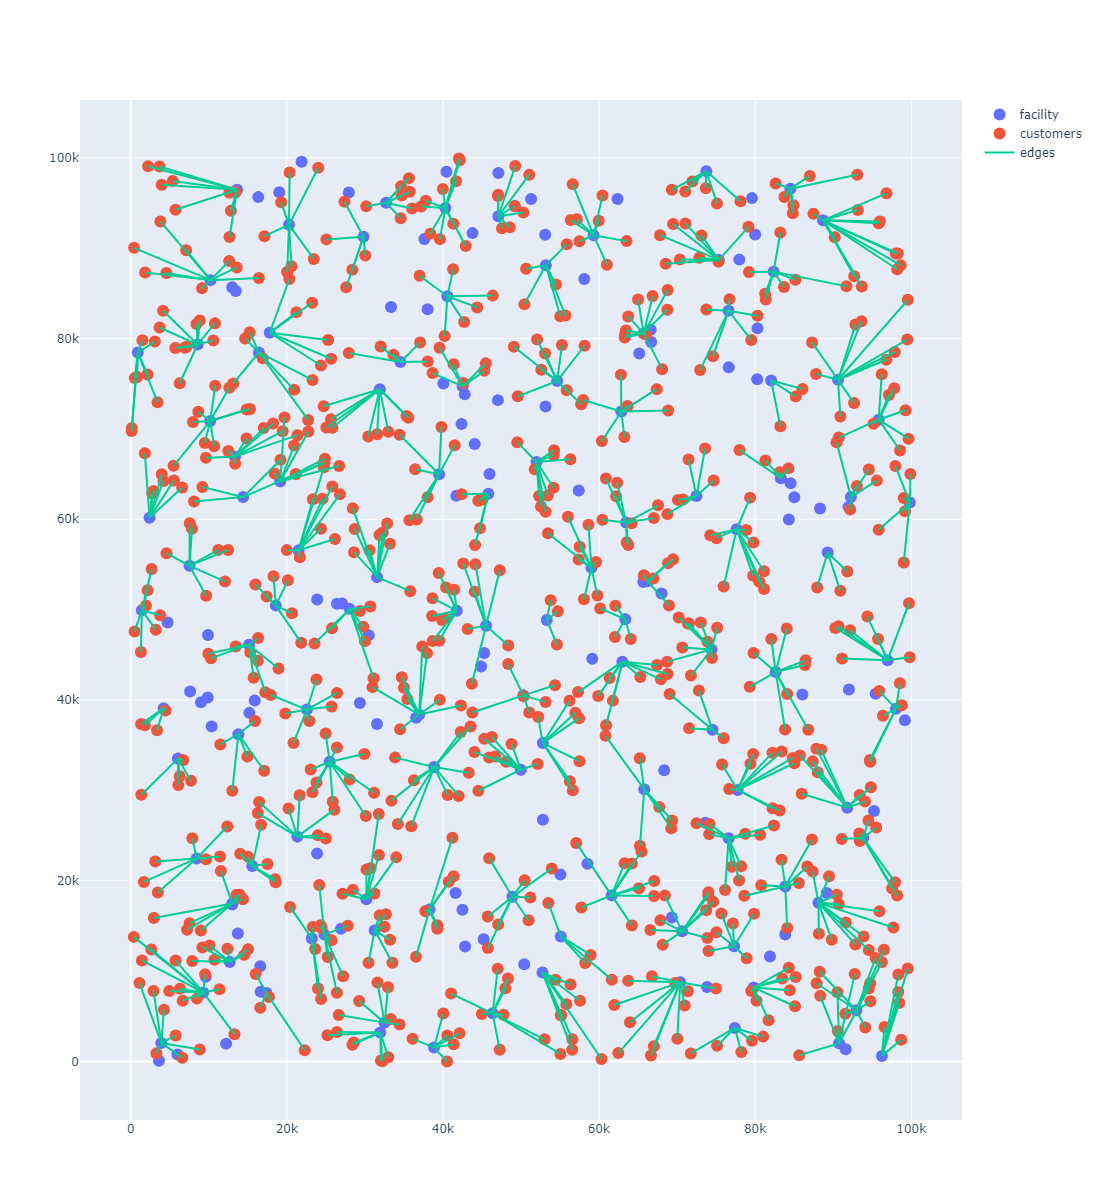

In [105]:
fig = go.Figure()

# Add traces
fig.add_trace(go.Scatter(x=f_x, y=f_y, 
                text=list(range(facility_count)),
                mode='markers',
                name='facility'))

fig.add_trace(go.Scatter(x=c_x, y=c_y,
                text=list(range(customer_count)),
                mode='markers',
                name='customers'))

fig.add_trace(go.Scatter(x=edge_x, y=edge_y,
                    mode='lines',
                    name='edges'))

fig.update_traces(marker=dict(size=12))
fig.update_layout(height=1200, width=1200)

fig.show()


In [68]:
total_cost

4768692.940354402

In [82]:
new_cost = total_cost
altering_facility_in_use = deepcopy(FACILITY_IN_USE)
altering_customer_mapping = deepcopy(CUSTOMER_MAPPING)
altering_facility_capacity = deepcopy(FACILITY_REMAINING_CAPACITY)

In [83]:
# CUSTOMER_MAPPING, FACILITY_IN_USE, FACILITY_REMAINING_CAPACITY

In [106]:
cx = 153

In [107]:
current_facility = altering_customer_mapping[cx]
current_facility

41

In [108]:
altering_facility_capacity[current_facility]

1599.0

In [109]:
customers[cx][1]

570.0

In [110]:
for ideal_facility in np.argsort(CUSTOMER_MATRIX[cx]):
    if ideal_facility == current_facility:
        continue
    break
    
# ideal_facility = np.argsort(CUSTOMER_MATRIX[cx])[0]

In [111]:
ideal_facility

165

In [112]:
current_facility == ideal_facility

False

In [113]:
delta_change = CUSTOMER_MATRIX[cx][ideal_facility]-CUSTOMER_MATRIX[cx][current_facility]
delta_change

-3919.2443212941876

In [114]:
#give back the capacity to current facility
altering_facility_capacity[current_facility] += customers[cx][1]
new_cost -= CUSTOMER_MATRIX[cx][current_facility]

#assign new facility
altering_customer_mapping[cx] = ideal_facility

#take capacity from ideal facility
altering_facility_capacity[ideal_facility] -= customers[cx][1]
new_cost += CUSTOMER_MATRIX[cx][ideal_facility]

In [115]:
altering_facility_capacity[ideal_facility]

-445.0

In [116]:
new_cost < total_cost, np.where(altering_facility_capacity<0)[0].size > 0

(True, True)

In [117]:
np.where(altering_facility_capacity<0)[0]

array([165], dtype=int64)

In [118]:
ideal_facility

165

In [119]:
current_facility

41

In [122]:
visited = [cx]

In [123]:
best_change = float('inf')
best_swap_facility = None
best_swap_customer = None
serving_customers = np.where(altering_customer_mapping == ideal_facility)[0]
print(serving_customers)
# filter_facilities = facility_count//10

for check_cx in serving_customers:
    for check_fac in np.argsort(FACILITY_MATRIX[ideal_facility])[:10]: ## Filter only active ones
        
        if check_fac == ideal_facility or not altering_facility_in_use[check_fac] or check_cx in visited:
            continue

        delta_change = CUSTOMER_MATRIX[check_cx][check_fac]-CUSTOMER_MATRIX[check_cx][ideal_facility]

        # net_change = CUSTOMER_MATRIX[check_cx][check_fac]-CUSTOMER_MATRIX[check_cx][ideal_facility] + delta_change
    
        added_cost_ideal_facility = altering_facility_capacity[ideal_facility]+customers[check_cx][1]
        remove_cost_current_facility = altering_facility_capacity[check_fac]-customers[check_cx][1]

        # print(check_cx, check_fac, added_cost_ideal_facility+remove_cost_current_facility)
        
        if delta_change < best_change and added_cost_ideal_facility>0 and remove_cost_current_facility>0:
            best_change = delta_change
            best_swap_customer = check_cx
            best_swap_facility = check_fac
            
added_cost_ideal_facility = altering_facility_capacity[ideal_facility]+customers[best_swap_customer][1]
remove_cost_current_facility = altering_facility_capacity[best_swap_facility]-customers[best_swap_customer][1]

best_swap_facility, best_swap_customer, added_cost_ideal_facility, remove_cost_current_facility

[116 121 153 218 226 386 463 633 705]


(34, 633, 53.0, 1433.0)

In [100]:
best_swap_facility, best_swap_customer

(41, 153)

In [101]:
# take capacity from facility to swap
altering_facility_capacity[best_swap_facility] -= customers[best_swap_customer][1]
new_cost += CUSTOMER_MATRIX[best_swap_customer][best_swap_facility]

#assign new facility
altering_customer_mapping[best_swap_customer] = best_swap_facility

#give back the capacity to ideal facility
altering_facility_capacity[ideal_facility] += customers[best_swap_customer][1]
new_cost -= CUSTOMER_MATRIX[best_swap_customer][ideal_facility]


In [102]:
np.where(altering_facility_capacity<0)[0]

array([], dtype=int64)

In [ ]:
ideal_facility=np.where(altering_facility_capacity<0)[0][0]
visited.append(best_swap_customer)
ideal_facility, visited

In [ ]:
new_cost

In [ ]:
# ## Only if True and True. do this
# serving_customers = np.where(altering_customer_mapping == ideal_facility)[0]
# serving_customers


# best_change = float('inf')
# best_swap_customer = None


# for check_cx in serving_customers:

#     net_change = CUSTOMER_MATRIX[check_cx][current_facility]-CUSTOMER_MATRIX[check_cx][ideal_facility] + delta_change
    
#     added_cost_ideal_facility = altering_facility_capacity[ideal_facility]+customers[check_cx][1]
#     remove_cost_current_facility = altering_facility_capacity[current_facility]-customers[check_cx][1]
    
#     if net_change < best_change and added_cost_ideal_facility>0 and remove_cost_current_facility>0:
#         best_change = net_change
#         best_swap_customer = check_cx

# print(best_change, best_swap_customer)



# # take capacity from facility to swap
# altering_facility_capacity[current_facility] -= customers[best_swap_customer][1]
# new_cost += CUSTOMER_MATRIX[best_swap_customer][current_facility]

# #assign new facility
# altering_customer_mapping[best_swap_customer] = current_facility

# #give back the capacity to ideal facility
# altering_facility_capacity[ideal_facility] += customers[best_swap_customer][1]
# new_cost -= CUSTOMER_MATRIX[best_swap_customer][ideal_facility]


# print(new_cost)

In [ ]:
new_cost

In [ ]:
total_cost

In [35]:
## Validate COST
temp_cost = 0
temp_fac_in_use = np.zeros(200, dtype=int)
temp_fac_capacity = deepcopy(facilities[:, 2])

for cx_idx, fc_idx in enumerate(CUSTOMER_MAPPING):
    
        facility_capacity = temp_fac_capacity[fc_idx]
        customer_demand = customers[cx_idx][1]
        
        if not temp_fac_in_use[fc_idx]:
            temp_fac_in_use[fc_idx] = 1
            temp_cost += facilities[fc_idx][1]

        temp_cost += CUSTOMER_MATRIX[cx_idx][fc_idx]
        temp_fac_capacity[fc_idx] -= customer_demand

temp_cost, total_cost

(5386692.767235839, 4493585.690835837)

In [ ]:
np.where(altering_facility_capacity<0)[0].size

In [ ]:
4493585.690835837